In [1]:
!pip install face_recognition

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import face_recognition
import numpy as np
import cv2
from PIL import Image
import torch.nn as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=f8f33856b600143555d1b378e27169da477653e86439b63211b40a3b4aa29a5d
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [2]:

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.actor_names = sorted(os.listdir(data_dir))
        self.actor_to_label = {actor_name: label for label, actor_name in enumerate(self.actor_names)}
        self.images = []
        self.labels = []

        for label, actor_name in enumerate(self.actor_names):
            actor_dir = os.path.join(data_dir, actor_name)
            image_names = os.listdir(actor_dir)
            for image_name in image_names:
                image_path = os.path.join(actor_dir, image_name)
                self.images.append(image_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



In [3]:
# Define data preprocessing and augmentation transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if torch.cuda.is_available:
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU available


In [28]:
import torch.optim as optim

# Create dataset and dataloader
dataset = CustomDataset(data_dir='/content/drive/MyDrive/FaceRecognition/Training_Dataset cropped', transform=data_transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Load the pre-trained ResNet-18 model
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True).to(device)
# Modify the last layer for your specific project
num_classes = len(os.listdir('/content/drive/MyDrive/FaceRecognition/Training_Dataset cropped'))
print(num_classes)

for parameter in model.parameters():
    parameter.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
).to(device)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

5


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [29]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.4680
Epoch [2/20], Loss: 0.2864
Epoch [3/20], Loss: 1.9391
Epoch [4/20], Loss: 0.8128
Epoch [5/20], Loss: 0.0779
Epoch [6/20], Loss: 2.3989
Epoch [7/20], Loss: 0.0157
Epoch [8/20], Loss: 0.0444
Epoch [9/20], Loss: 3.0501
Epoch [10/20], Loss: 0.3950
Epoch [11/20], Loss: 2.1231
Epoch [12/20], Loss: 0.0711
Epoch [13/20], Loss: 0.3669
Epoch [14/20], Loss: 0.2516
Epoch [15/20], Loss: 0.2176
Epoch [16/20], Loss: 0.1025
Epoch [17/20], Loss: 0.0090
Epoch [18/20], Loss: 0.8032
Epoch [19/20], Loss: 2.1134
Epoch [20/20], Loss: 0.1350


In [30]:

# Load and preprocess the single test image
test_image = Image.open("/content/drive/MyDrive/FaceRecognition/123.jpeg").convert("RGB")
test_image_np = np.array(test_image)

# Use face_recognition library to detect face bounding boxes
face_locations = face_recognition.face_locations(test_image_np)

# Initialize a list to store recognized names and corresponding face locations
recognized_names = []
recognized_face_locations = []


In [31]:
# Use the trained model for recognition
model.eval()
with torch.no_grad():
    for face_location in face_locations:
        top, right, bottom, left = face_location
        face_image = test_image.crop((left, top, right, bottom))
        face_image = data_transform(face_image).unsqueeze(0)
        outputs = model(face_image.to(device)).to('cpu')
        _, predicted = torch.max(outputs, 1)
        predicted_label = predicted.item()
        recognized_name = dataset.actor_names[predicted_label]
        recognized_names.append(recognized_name)
        recognized_face_locations.append(face_location)


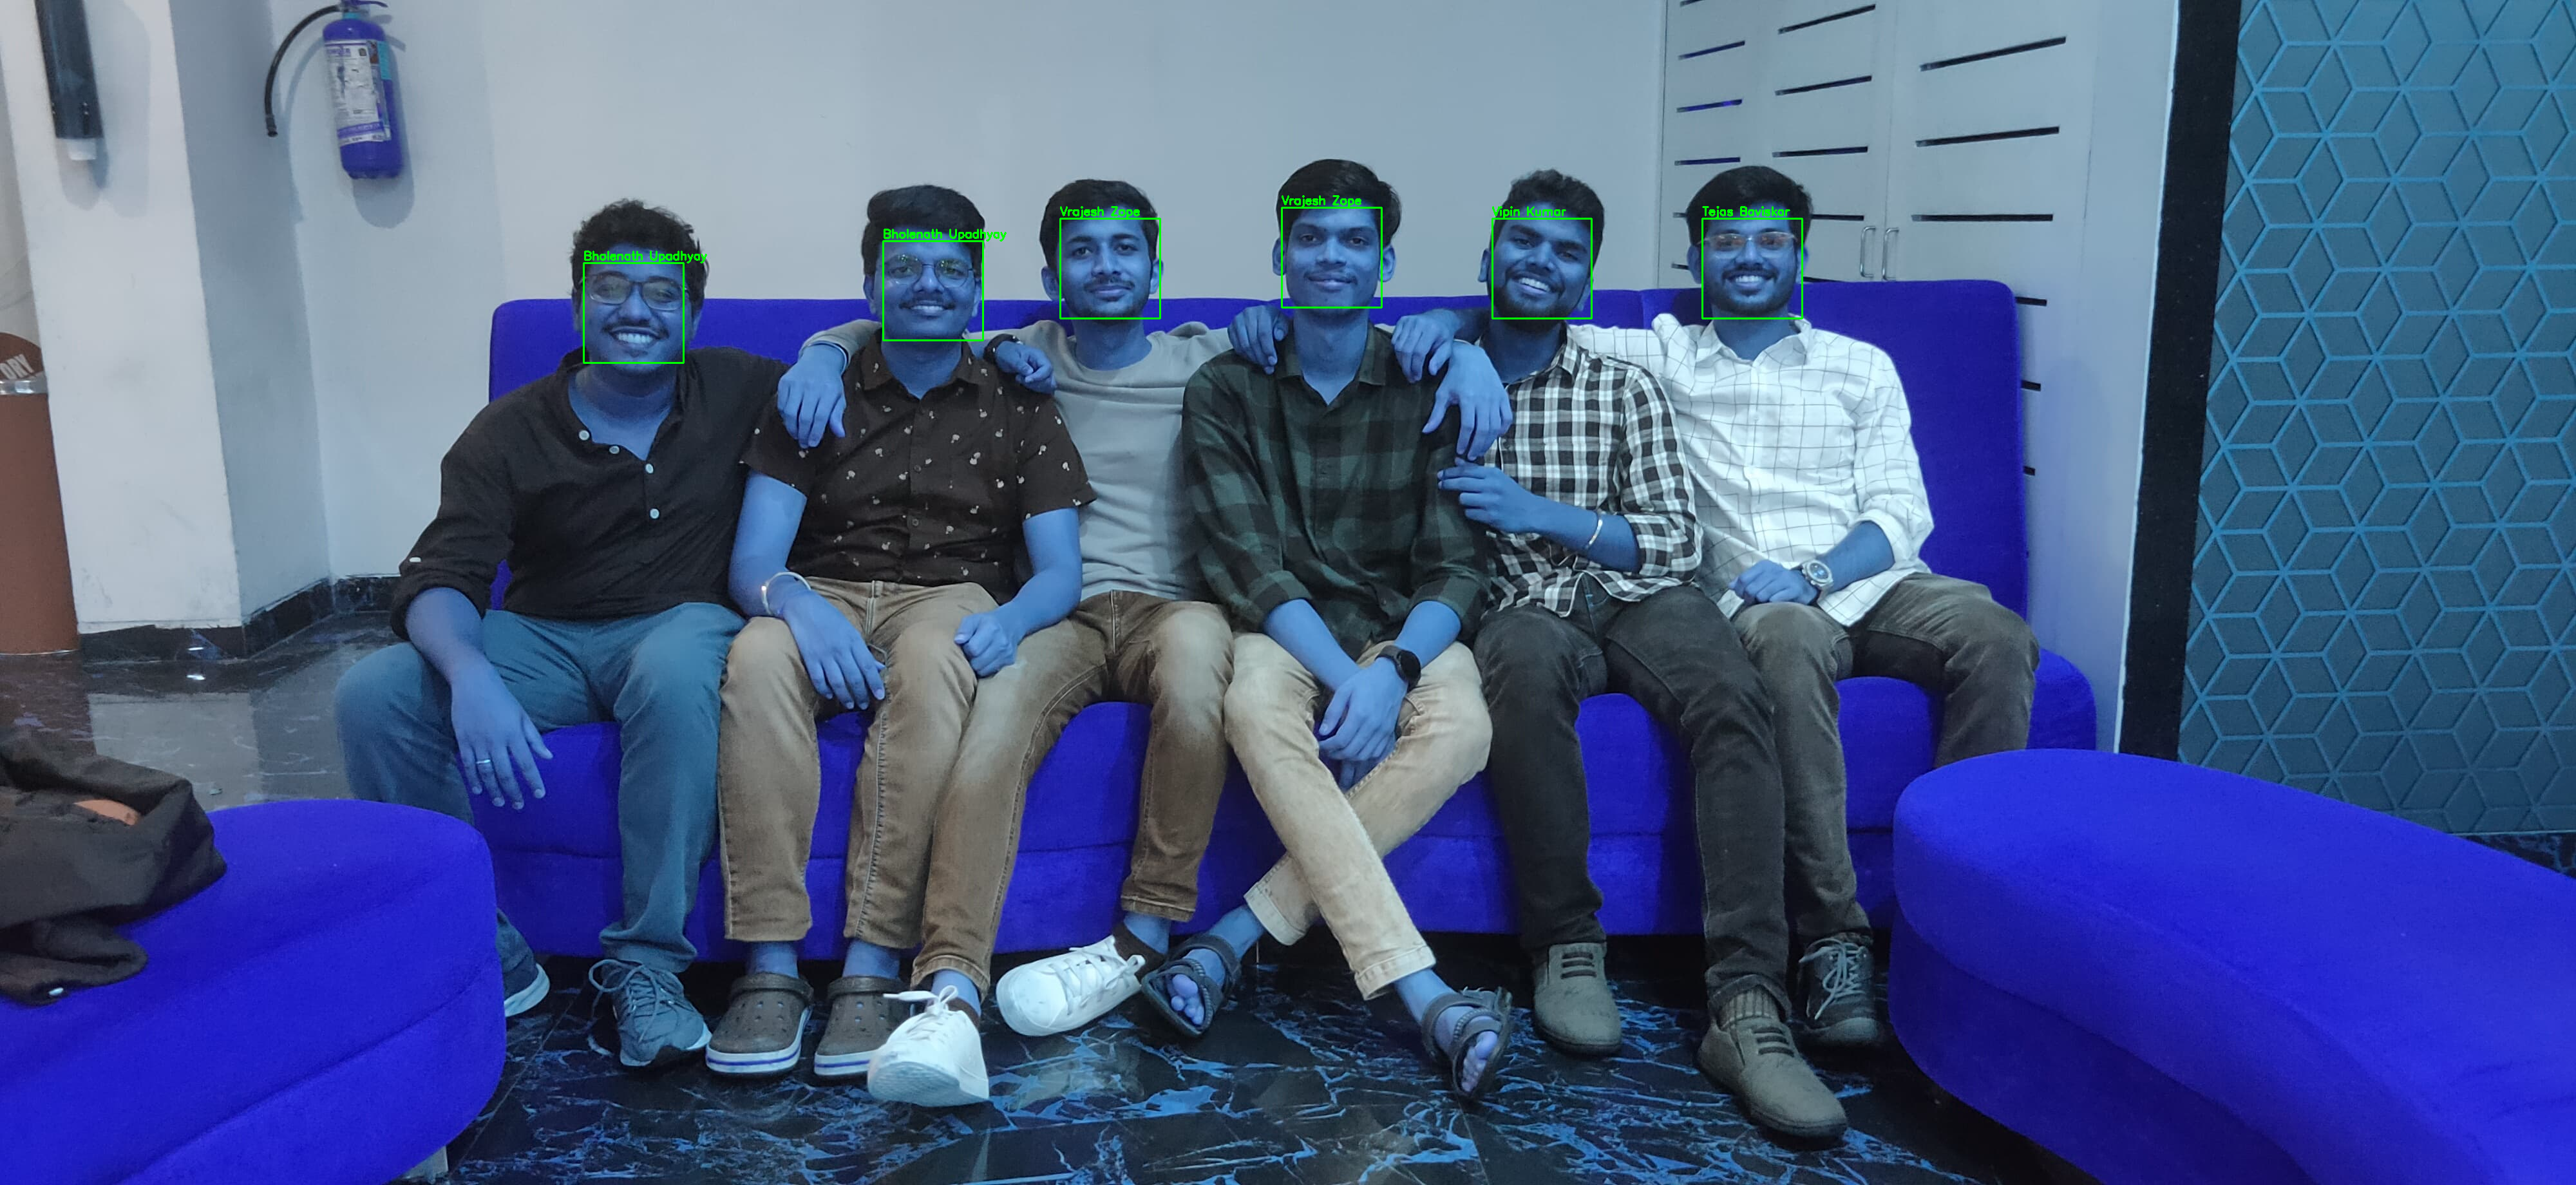

In [32]:

from google.colab.patches import cv2_imshow

# Draw bounding boxes and names on the image using OpenCV
image_with_boxes = test_image_np.copy()
for (top, right, bottom, left), name in zip(recognized_face_locations, recognized_names):
    cv2.rectangle(image_with_boxes, (left, top), (right, bottom), (0, 255, 0), 2)
    cv2.putText(image_with_boxes, name, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Display the image using cv2_imshow()
cv2_imshow(image_with_boxes)



# New Section